In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!ls "/content/drive/My Drive/Computer Vision/Final Project"

CSE237D_Rock_Climbing_Coach-main					     predict_holds.py
eval_move_valid_utils.py						     __pycache__
images									     requirements.txt
mediapipe-0.8.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl  utils
mediapipe-0.8.10-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl    videos
move_validity_utils.py


In [40]:
!cp "/content/drive/My Drive/Computer Vision/Final Project/mediapipe-0.8.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl" .

In [41]:
!pip install mediapipe-0.8.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing ./mediapipe-0.8.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
mediapipe is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [42]:
!pip install -r "/content/drive/My Drive/Computer Vision/Final Project/requirements.txt"

In [43]:
import cv2
import mediapipe as mp
import time
from scipy import spatial
from IPython.core.display import ProgressBar
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [80]:
VIDEO_PATH = '/content/drive/My Drive/Computer Vision/Final Project/videos/1.mp4'
HOLDS_PATH = '/content/drive/My Drive/Computer Vision/Final Project/images/combine_images.jpg'
width = 576
height = 1080

In [76]:
def array(vid_path):
    cap = cv2.VideoCapture(vid_path)
    vid_arr = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        vid_arr.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    cap.release()
    return np.array(vid_arr)

cropped = array(VIDEO_PATH)
cropped.shape

(531, 1280, 720, 3)

In [92]:
def crop(vid_arr, new_width, new_height):
    cropped_video = []
    for frame in vid_arr:
        im = Image.fromarray(frame)

        width, height = im.size
        left = (width - new_width) // 2
        top = (height - new_height) // 2
        right = left + new_width
        bottom = top + new_height

        cropped_video.append(np.array(im.crop((left, top, right, bottom))))

    return np.array(cropped_video)

In [79]:
def pose(vid_arr):
    pose = mp.solutions.pose.Pose()
    dict_coordinates = {
        'left_hand': [], 'right_hand': [],
        'left_hip': [], 'right_hip': [],
        'left_leg': [], 'right_leg': []
    }
    all_landmarks = []
    all_results = []
    frames = []

    for i, img in enumerate(vid_arr):
        results = pose.process(img)

        if results.pose_landmarks is not None:
            frames.append(i)
            h, w, _ = img.shape
            lm_list = [
                (int(lm.x * w), int(lm.y * h))
                for lm in results.pose_landmarks.landmark
            ]

            flat_lm_list = [coord for pair in lm_list for coord in pair]
            all_landmarks.append(flat_lm_list)
            all_results.append(results)

            dict_coordinates['left_hand'].append(lm_list[19])
            dict_coordinates['right_hand'].append(lm_list[20])
            dict_coordinates['left_hip'].append(lm_list[23])
            dict_coordinates['right_hip'].append(lm_list[24])
            dict_coordinates['left_leg'].append(lm_list[31])
            dict_coordinates['right_leg'].append(lm_list[32])

    return frames, all_results, all_landmarks, dict_coordinates

frames, results_arr, landmarks_arr, joint_positions = pose(cropped)
cropped = cropped.take(frames, axis=0)

In [82]:
def significant(landmarks):
    from scipy.spatial.distance import cosine
    significant = []
    prev = None
    for i, current in enumerate(landmarks):
        if i == 0 or (1 - cosine(prev, current)) < 0.99999:
            significant.append(True)
        else:
            significant.append(False)
        prev = current
    return significant

significances = significant(landmarks_arr)

In [83]:
import sys
sys.path.append('/content/drive/My Drive/Computer Vision/Final Project')

import predict_holds

In [84]:
hold_img = cv2.cvtColor(cv2.imread(HOLDS_PATH), cv2.COLOR_BGR2RGB)
status, response = predict_holds.predict_holds(hold_img)

In [86]:
def hold(dic):
    holds = [
        [
            (int(elem['x'] - elem['width'] / 2), int(elem['y'] - elem['height'] / 2)),
            (int(elem['x'] + elem['width'] / 2), int(elem['y'] + elem['height'] / 2))
        ]
        for elem in dic['predictions']
    ]
    return holds

climb_holds = hold(response)

In [87]:
def usedholds(holds, dict_coordinates):
    joint_list = list(zip(
        dict_coordinates['left_hand'],
        dict_coordinates['right_hand'],
        dict_coordinates['left_leg'],
        dict_coordinates['right_leg']
    ))

    holds_used = []
    for i in range(len(joint_list)):
        used_arr = []
        for hold in holds:
            jx_min, jy_min = hold[0]
            jx_max, jy_max = hold[1]

            current_usage = any(
                jx_min <= joint[0] <= jx_max and jy_min <= joint[1] <= jy_max
                for joint in joint_list[i]
            )

            if current_usage and i + 1 < len(joint_list):
                next_usage = any(
                    jx_min <= joint[0] <= jx_max and jy_min <= joint[1] <= jy_max
                    for joint in joint_list[i + 1]
                )
                used_arr.append(next_usage)
            else:
                used_arr.append(current_usage)
        holds_used.append(used_arr)

    return holds_used

climb_holds_used = usedholds(climb_holds, joint_positions)

In [90]:
def videogenerator(vid_arr, holds, holds_used, pose_results, dict_coordinates, frame_significances):
    joint_list = list(zip(
        dict_coordinates['left_hand'],
        dict_coordinates['right_hand'],
        dict_coordinates['left_hip'],
        dict_coordinates['right_hip'],
        dict_coordinates['left_leg'],
        dict_coordinates['right_leg']
    ))

    plotted_frames = []

    for t, frame in enumerate(vid_arr):
        if not frame_significances[t]:
            continue

        used = holds_used[t]
        results = pose_results[t]

        for h, is_used in enumerate(used):
            if is_used:
                frame = cv2.rectangle(frame, holds[h][0], holds[h][1], (0, 255, 120), 5)

        mp.solutions.drawing_utils.draw_landmarks(
            frame, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS
        )

        for cx, cy in joint_list[t]:
            frame = cv2.circle(frame, (cx, cy), 5, (255, 0, 150), cv2.FILLED)

        plotted_frames.append(frame)

    return np.array(plotted_frames)

video = videogenerator(cropped, climb_holds, climb_holds_used, results_arr, joint_positions, significances)
video.shape

(485, 1280, 720, 3)

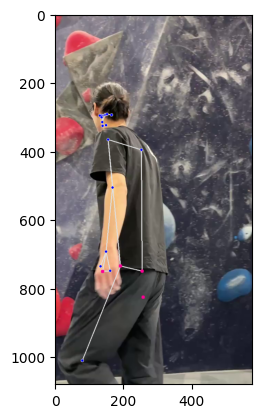

In [95]:
test = crop(video, width, height)
plt.imshow(test[0])

In [96]:
frameSize = (width, height)
fourcc= cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('test.avi', fourcc, 5, (width, height), isColor=True)

for i in range(test.shape[0]):
    img = test[i]
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()

In [97]:
!ls

drive									     sample_data
mediapipe-0.8.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl  test.avi


In [98]:
!pwd

/content


In [99]:
from google.colab import files
files.download('test.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>